In [1]:
import urllib.request

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
urllib.request.urlretrieve(url, 'car.data')

('car.data', <http.client.HTTPMessage at 0x7f048cdc4250>)

In [2]:
import numpy as np
data = np.loadtxt("car.data",dtype='str',delimiter=',')
X, y = data[:,:-1], data[:,-1]
X.shape, y.shape

((1728, 6), (1728,))

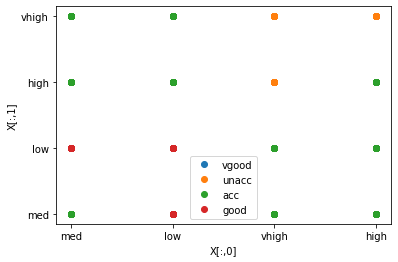

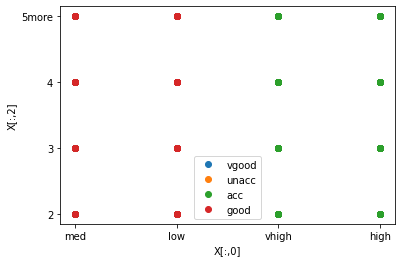

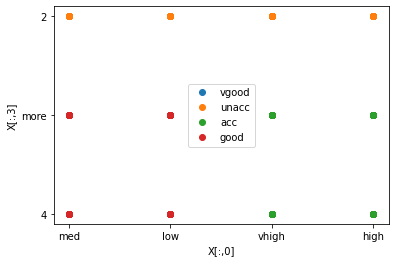

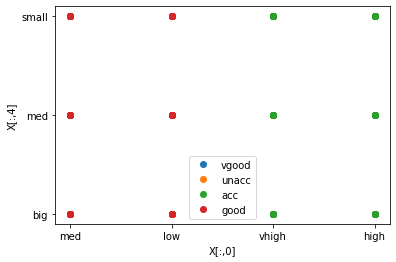

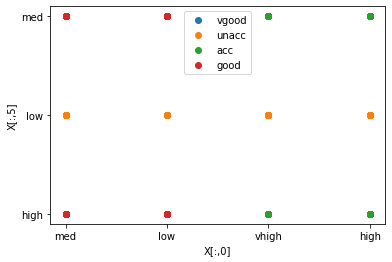

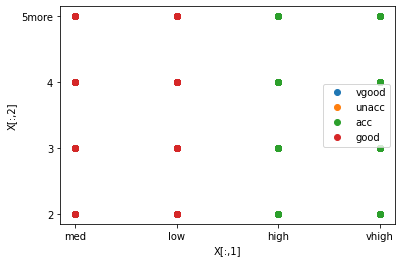

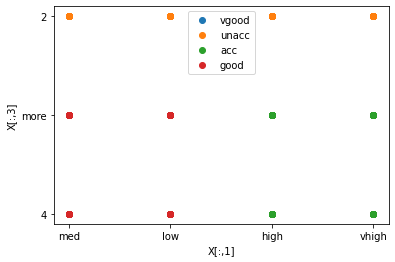

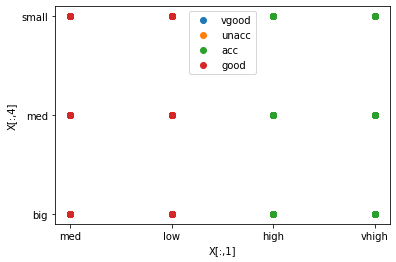

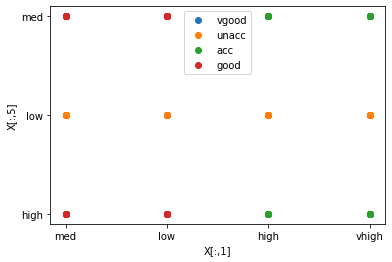

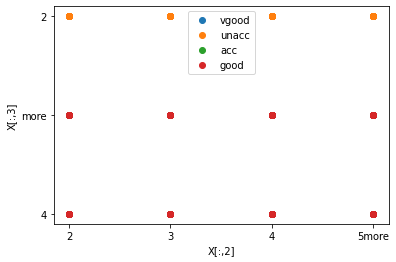

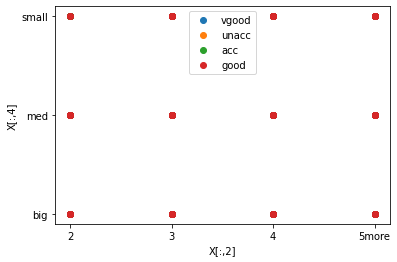

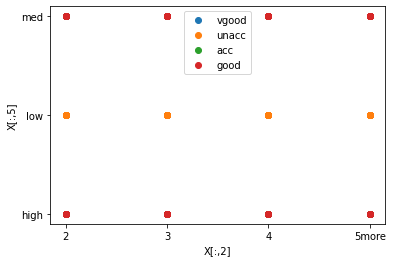

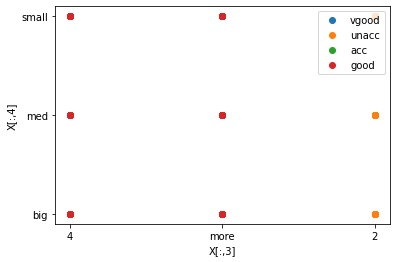

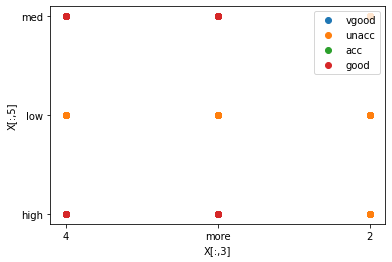

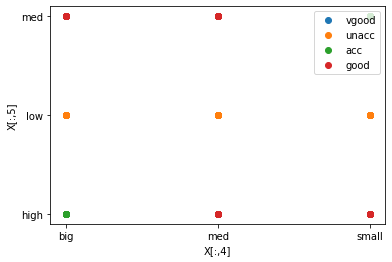

In [3]:
import matplotlib.pyplot as plt
for i in range(X.shape[1]):
    for j in range(i+1,X.shape[1]):
        plt.xlabel(f"X[:,{i}]")
        plt.ylabel(f"X[:,{j}]")
        for k in set(y):
            plt.plot(X[:,i][y==k], X[:,j][y==k], "o", label=k)
        plt.legend()
        plt.show()

In [4]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5')
        y[:] = self.resposta
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.7002314814814815, array([ True,  True,  True, ...,  True, False, False]))

In [5]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor

0.457283763074417

In [6]:
for i in range(X.shape[1]):
    valores = set(X[:,i])
    print(valores)

{'med', 'low', 'high', 'vhigh'}
{'med', 'low', 'high', 'vhigh'}
{'4', '5more', '2', '3'}
{'4', '2', 'more'}
{'med', 'small', 'big'}
{'high', 'low', 'med'}


In [7]:
def impurezaValor(x, y, valor):
    iguais = x==valor
    impurezaiguais = impureza(y[iguais])
    propiguais = (sum(iguais)/len(y))
    impurezadiferentes = impureza(y[~iguais])
    propdiferentes = (sum(~iguais)/len(y))
    impurezatotal =  propiguais*impurezaiguais + propdiferentes*impurezadiferentes
    return impurezatotal
impurezaValor(X[:,0], y, 'vhigh')

0.44934645776177407

In [8]:
def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for f in valores:
            caracteristicasValores.append([i, f])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, f)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    # print(np.concatenate((caracteristicasValores,np.array([impurezas]).T),axis=1))
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza],int(caracteristica), valor
impurezaMinima(X, y)

(0.38615712609310704, 3, '2')

In [9]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.impureza, self.caracteristica, self.valor = impurezaMinima(X, y)
        iguais = X[:,self.caracteristica] == self.valor
        self.resposta = maisFrequente(y)
        if sum(iguais) > 0 and sum(iguais)<len(iguais):
            self.iguais = Arvore()
            self.iguais.fit(X[iguais,:], y[iguais])
        if sum(~iguais) > 0 and sum(~iguais)<len(~iguais):
            self.diferentes = Arvore()
            self.diferentes.fit(X[~iguais,:], y[~iguais])            
    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5')
        iguais = X[:,self.caracteristica] == self.valor
        if hasattr(self, 'iguais'):
            y[iguais] = self.iguais.predict(X[iguais,:])
        else:
            y[iguais] = self.resposta
        if hasattr(self, 'diferentes'):
            y[~iguais] = self.diferentes.predict(X[~iguais,:])
        else:
            y[~iguais] = self.resposta
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(1.0, array([ True,  True,  True, ...,  True,  True,  True]))

In [10]:
from sklearn.model_selection import cross_validate

scores = cross_validate(Arvore(), X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.96050048, 0.96309114, 0.99878478, 0.98956966, 1.05917168]),
  'score_time': array([0.00124311, 0.0013361 , 0.00136161, 0.0013423 , 0.00112438]),
  'test_score': array([0.62716763, 0.73121387, 0.75144509, 0.75362319, 0.8057971 ])},
 0.7338493758900897)